In [1]:
import os

ROOT = r"C:\Users\ADMIN\Desktop\NDM_Project"
need = [
    r"results\cnn_baseline.pt",
    r"results\X_train_deep.npy",
    r"results\X_val_deep.npy",
    r"results\X_test_deep.npy",
    r"configs\spectrogram.json",
    r"configs\cnn.json",
    r"data\splits\cwru_splits.json",
]
for p in need:
    fp = os.path.join(ROOT, p)
    print("OK " if os.path.exists(fp) else "MISS", fp)


OK  C:\Users\ADMIN\Desktop\NDM_Project\results\cnn_baseline.pt
OK  C:\Users\ADMIN\Desktop\NDM_Project\results\X_train_deep.npy
OK  C:\Users\ADMIN\Desktop\NDM_Project\results\X_val_deep.npy
OK  C:\Users\ADMIN\Desktop\NDM_Project\results\X_test_deep.npy
OK  C:\Users\ADMIN\Desktop\NDM_Project\configs\spectrogram.json
OK  C:\Users\ADMIN\Desktop\NDM_Project\configs\cnn.json
OK  C:\Users\ADMIN\Desktop\NDM_Project\data\splits\cwru_splits.json


In [2]:
%%writefile C:\Users\ADMIN\Desktop\NDM_Project\configs\fusion.json
{
  "seed": 42,
  "C_grid": [0.1, 1.0, 10.0, 100.0],
  "alpha_grid": [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.0]
}


Writing C:\Users\ADMIN\Desktop\NDM_Project\configs\fusion.json


In [3]:
%%writefile C:\Users\ADMIN\Desktop\NDM_Project\src\run_phase8_fusion.py
import os
import sys
import json
import csv
import random
from typing import Tuple, List, Dict

import numpy as np

import torch
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt

# allow import from src/
ROOT = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
sys.path.append(os.path.join(ROOT, "src"))

from dataio import load_splits_json, iter_segments_from_record
from spectrogram import make_spectrogram
from cnn_model import CNNBaseline
from features_prml import extract_features


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)


def load_json(path: str) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def save_json(path: str, obj: dict):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)


def save_csv(path: str, rows: List[dict]):
    if not rows:
        return
    with open(path, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
        w.writeheader()
        for r in rows:
            w.writerow(r)


def plot_cm(cm: np.ndarray, class_names: List[str], out_png: str, title: str):
    plt.figure(figsize=(9, 7))
    plt.imshow(cm, aspect="auto")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(range(len(class_names)), class_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=8)

    plt.colorbar()
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()


def fit_logreg_with_val(
    Xtr: np.ndarray, ytr: np.ndarray,
    Xva: np.ndarray, yva: np.ndarray,
    C_grid: List[float],
    seed: int
) -> Tuple[StandardScaler, LogisticRegression, dict]:
    best = {"C": None, "val_acc": -1.0, "val_macro_f1": -1.0}
    best_scaler = None
    best_clf = None

    for C in C_grid:
        scaler = StandardScaler()
        Xtr_s = scaler.fit_transform(Xtr)
        Xva_s = scaler.transform(Xva)

        clf = LogisticRegression(
            C=float(C),
            max_iter=5000,
            solver="lbfgs",
            multi_class="auto",
            n_jobs=None,
            random_state=seed
        )
        clf.fit(Xtr_s, ytr)

        p = clf.predict(Xva_s)
        acc = accuracy_score(yva, p)
        mf1 = f1_score(yva, p, average="macro")

        improved = (mf1 > best["val_macro_f1"]) or (mf1 == best["val_macro_f1"] and acc > best["val_acc"])
        if improved:
            best = {"C": float(C), "val_acc": float(acc), "val_macro_f1": float(mf1)}
            best_scaler = scaler
            best_clf = clf

    return best_scaler, best_clf, best


def build_spectrogram_xy(
    split_name: str,
    records_map: Dict,
    splits: Dict,
    fs: int,
    seg_len: int,
    hop_len: int,
    spec_cfg: dict,
    label_to_idx: Dict[str, int],
) -> Tuple[np.ndarray, np.ndarray]:
    X_list = []
    y_list = []
    for rid in splits[split_name]:
        rec = records_map[rid]
        for seg in iter_segments_from_record(ROOT, rec, seg_len=seg_len, hop_len=hop_len, normalize=False):
            S, _ = make_spectrogram(
                seg,
                fs=fs,
                window_type=spec_cfg["window_type"],
                win_length=int(spec_cfg["win_length"]),
                hop_length=int(spec_cfg["hop_length"]),
                n_fft=int(spec_cfg["n_fft"]),
                use_mel=bool(spec_cfg["use_mel"]),
                n_mels=int(spec_cfg["mel_bins"]),
                fmin=float(spec_cfg["fmin"]),
                fmax=spec_cfg["fmax"],
                power=float(spec_cfg["power"]),
                log_eps=float(spec_cfg["log_eps"]),
                to_db=bool(spec_cfg["to_db"]),
            )
            S = np.asarray(S, dtype=np.float32)      # (F,T)
            X_list.append(S[None, ...])              # (1,F,T)
            y_list.append(label_to_idx[rec["label"]])

    X = np.stack(X_list, axis=0).astype(np.float32)
    y = np.asarray(y_list, dtype=np.int64)
    return X, y


def build_shallow_xy(
    split_name: str,
    records_map: Dict,
    splits: Dict,
    fs: int,
    seg_len: int,
    hop_len: int,
    label_to_idx: Dict[str, int],
) -> Tuple[np.ndarray, np.ndarray]:
    X_list = []
    y_list = []
    for rid in splits[split_name]:
        rec = records_map[rid]
        for seg in iter_segments_from_record(ROOT, rec, seg_len=seg_len, hop_len=hop_len, normalize=False):
            # signature safety
            try:
                feat = extract_features(seg, fs=fs)
            except TypeError:
                feat = extract_features(seg, fs)

            feat = np.asarray(feat, dtype=np.float32).reshape(-1)
            X_list.append(feat)
            y_list.append(label_to_idx[rec["label"]])

    X = np.stack(X_list, axis=0).astype(np.float32)
    y = np.asarray(y_list, dtype=np.int64)
    return X, y


def deep_predict_proba(model: torch.nn.Module, X: np.ndarray, device: str, batch: int = 128) -> np.ndarray:
    model.eval()
    probs = []
    with torch.no_grad():
        for i in range(0, X.shape[0], batch):
            xb = torch.tensor(X[i:i+batch]).to(device)
            logits = model(xb)
            p = F.softmax(logits, dim=1).cpu().numpy().astype(np.float32)
            probs.append(p)
    return np.vstack(probs)


def main():
    results_dir = os.path.join(ROOT, "results")
    cfg_dir = os.path.join(ROOT, "configs")
    ensure_dir(results_dir)

    fusion_cfg_path = os.path.join(cfg_dir, "fusion.json")
    fusion_cfg = load_json(fusion_cfg_path) if os.path.exists(fusion_cfg_path) else {"seed": 42}

    cnn_cfg = load_json(os.path.join(cfg_dir, "cnn.json"))
    spec_cfg = load_json(os.path.join(cfg_dir, "spectrogram.json"))

    seed = int(fusion_cfg.get("seed", cnn_cfg.get("seed", 42)))
    set_seed(seed)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    seg_len = int(cnn_cfg.get("seg_len", 4096))
    hop_len = int(cnn_cfg.get("hop_len", 4096))

    C_grid = fusion_cfg.get("C_grid", [0.1, 1.0, 10.0, 100.0])
    alpha_grid = fusion_cfg.get("alpha_grid", [i/20 for i in range(21)])

    print("ROOT   =", ROOT)
    print("device =", device)
    print("seg_len/hop_len =", seg_len, hop_len)
    print("C_grid =", C_grid)
    print("alpha_grid size =", len(alpha_grid))

    # load splits
    split_path = os.path.join(ROOT, "data", "splits", "cwru_splits.json")
    records_map, splits, meta = load_splits_json(ROOT, split_path)
    fs = int(meta["fs"])

    tr, va, te = set(splits["train"]), set(splits["val"]), set(splits["test"])
    print("split sizes:", {k: len(v) for k, v in splits.items()})
    print("intersections:", len(tr & va), len(tr & te), len(va & te))

    # load deep model ckpt (Phase 7)
    ckpt_path = os.path.join(results_dir, "cnn_baseline.pt")
    ckpt = torch.load(ckpt_path, map_location=device)

    class_names = list(ckpt["class_names"])
    label_to_idx = {c: i for i, c in enumerate(class_names)}
    n_classes = len(class_names)

    train_norm = ckpt.get("train_norm", {"mean": 0.0, "std": 1.0})
    mean = float(train_norm["mean"])
    std = float(train_norm["std"])

    model = CNNBaseline(n_classes=n_classes, emb_dim=int(cnn_cfg.get("emb_dim", 128))).to(device)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()

    # =========================================================
    # A) SCORE-LEVEL FUSION (weighted-sum on probabilities)
    # =========================================================
    print("\n[Phase 8A] Build spectrogram tensors (for deep probs)...")
    Xtr_spec, ytr = build_spectrogram_xy("train", records_map, splits, fs, seg_len, hop_len, spec_cfg, label_to_idx)
    Xva_spec, yva = build_spectrogram_xy("val",   records_map, splits, fs, seg_len, hop_len, spec_cfg, label_to_idx)
    Xte_spec, yte = build_spectrogram_xy("test",  records_map, splits, fs, seg_len, hop_len, spec_cfg, label_to_idx)

    # normalize by saved train mean/std
    Xtr_spec = (Xtr_spec - mean) / (std + 1e-6)
    Xva_spec = (Xva_spec - mean) / (std + 1e-6)
    Xte_spec = (Xte_spec - mean) / (std + 1e-6)

    print("spec shapes:", Xtr_spec.shape, Xva_spec.shape, Xte_spec.shape)

    print("\n[Phase 8A] Build shallow features (for shallow probs)...")
    Xtr_sh, ytr2 = build_shallow_xy("train", records_map, splits, fs, seg_len, hop_len, label_to_idx)
    Xva_sh, yva2 = build_shallow_xy("val",   records_map, splits, fs, seg_len, hop_len, label_to_idx)
    Xte_sh, yte2 = build_shallow_xy("test",  records_map, splits, fs, seg_len, hop_len, label_to_idx)

    assert np.all(ytr == ytr2) and np.all(yva == yva2) and np.all(yte == yte2), "Label mismatch between deep/shallow build!"
    print("shapes shallow:", Xtr_sh.shape, Xva_sh.shape, Xte_sh.shape)

    # train shallow classifier (tune C on val)
    print("\n[Phase 8A] Train shallow classifier (LogReg) + tune C on val...")
    sh_scaler, sh_clf, sh_best = fit_logreg_with_val(Xtr_sh, ytr, Xva_sh, yva, C_grid, seed)
    print("best shallow:", sh_best)

    # probs
    Xva_sh_s = sh_scaler.transform(Xva_sh)
    Xte_sh_s = sh_scaler.transform(Xte_sh)
    Pva_sh = sh_clf.predict_proba(Xva_sh_s).astype(np.float32)
    Pte_sh = sh_clf.predict_proba(Xte_sh_s).astype(np.float32)

    Pva_deep = deep_predict_proba(model, Xva_spec, device=device, batch=128)
    Pte_deep = deep_predict_proba(model, Xte_spec, device=device, batch=128)

    # alpha sweep on val
    best_alpha = {"alpha": None, "val_acc": -1.0, "val_macro_f1": -1.0}
    for a in alpha_grid:
        a = float(a)
        P = a * Pva_deep + (1.0 - a) * Pva_sh
        pred = np.argmax(P, axis=1)
        acc = accuracy_score(yva, pred)
        mf1 = f1_score(yva, pred, average="macro")
        improved = (mf1 > best_alpha["val_macro_f1"]) or (mf1 == best_alpha["val_macro_f1"] and acc > best_alpha["val_acc"])
        if improved:
            best_alpha = {"alpha": a, "val_acc": float(acc), "val_macro_f1": float(mf1)}

    print("best alpha:", best_alpha)

    # test with best alpha
    a = best_alpha["alpha"]
    Pte = a * Pte_deep + (1.0 - a) * Pte_sh
    pte = np.argmax(Pte, axis=1)
    te_acc = accuracy_score(yte, pte)
    te_f1 = f1_score(yte, pte, average="macro")

    cm = confusion_matrix(yte, pte, labels=list(range(n_classes)))
    cm_score_path = os.path.join(results_dir, "cm_fusion_score.png")
    plot_cm(cm, class_names, cm_score_path, f"Fusion score-level (alpha={a:.2f}) - test")

    fusion_score_csv = os.path.join(results_dir, "fusion_score_metrics.csv")
    save_csv(fusion_score_csv, [{
        "method": "score_level_weighted_sum",
        "alpha": a,
        "shallow_best_C": sh_best["C"],
        "val_acc": best_alpha["val_acc"],
        "val_macro_f1": best_alpha["val_macro_f1"],
        "test_acc": float(te_acc),
        "test_macro_f1": float(te_f1),
    }])

    print("Saved:", fusion_score_csv)
    print("Saved:", cm_score_path)

    # =========================================================
    # B) FEATURE-LEVEL FUSION (concat deep_emb + shallow_feat)
    # =========================================================
    print("\n[Phase 8B] Feature-level fusion: load deep embeddings + concat with shallow feats...")

    Xtr_deep = np.load(os.path.join(results_dir, "X_train_deep.npy")).astype(np.float32)
    Xva_deep = np.load(os.path.join(results_dir, "X_val_deep.npy")).astype(np.float32)
    Xte_deep = np.load(os.path.join(results_dir, "X_test_deep.npy")).astype(np.float32)

    # shallow feats already built: Xtr_sh, Xva_sh, Xte_sh
    assert Xtr_deep.shape[0] == Xtr_sh.shape[0] and Xva_deep.shape[0] == Xva_sh.shape[0] and Xte_deep.shape[0] == Xte_sh.shape[0], \
        "Count mismatch deep vs shallow (segment order/params not consistent)."

    Xtr_f = np.concatenate([Xtr_deep, Xtr_sh], axis=1)
    Xva_f = np.concatenate([Xva_deep, Xva_sh], axis=1)
    Xte_f = np.concatenate([Xte_deep, Xte_sh], axis=1)

    print("fused shapes:", Xtr_f.shape, Xva_f.shape, Xte_f.shape)

    print("\n[Phase 8B] Train fused classifier (LogReg) + tune C on val...")
    fu_scaler, fu_clf, fu_best = fit_logreg_with_val(Xtr_f, ytr, Xva_f, yva, C_grid, seed)
    print("best fused:", fu_best)

    Xte_f_s = fu_scaler.transform(Xte_f)
    pte_f = fu_clf.predict(Xte_f_s)
    te_acc_f = accuracy_score(yte, pte_f)
    te_f1_f = f1_score(yte, pte_f, average="macro")

    cmf = confusion_matrix(yte, pte_f, labels=list(range(n_classes)))
    cm_feat_path = os.path.join(results_dir, "cm_fusion_feature.png")
    plot_cm(cmf, class_names, cm_feat_path, "Fusion feature-level (deep_emb + shallow_feat) - test")

    fusion_feat_csv = os.path.join(results_dir, "fusion_feature_metrics.csv")
    save_csv(fusion_feat_csv, [{
        "method": "feature_level_concat",
        "fused_best_C": fu_best["C"],
        "val_acc": fu_best["val_acc"],
        "val_macro_f1": fu_best["val_macro_f1"],
        "test_acc": float(te_acc_f),
        "test_macro_f1": float(te_f1_f),
        "deep_dim": int(Xtr_deep.shape[1]),
        "shallow_dim": int(Xtr_sh.shape[1]),
        "fused_dim": int(Xtr_f.shape[1]),
    }])

    print("Saved:", fusion_feat_csv)
    print("Saved:", cm_feat_path)

    info = {
        "class_names": class_names,
        "score_level": {
            "shallow_best": sh_best,
            "best_alpha": best_alpha,
            "test": {"acc": float(te_acc), "macro_f1": float(te_f1)},
            "saved": {"metrics_csv": fusion_score_csv, "cm_png": cm_score_path},
        },
        "feature_level": {
            "best": fu_best,
            "test": {"acc": float(te_acc_f), "macro_f1": float(te_f1_f)},
            "dims": {"deep": int(Xtr_deep.shape[1]), "shallow": int(Xtr_sh.shape[1]), "fused": int(Xtr_f.shape[1])},
            "saved": {"metrics_csv": fusion_feat_csv, "cm_png": cm_feat_path},
        }
    }
    info_path = os.path.join(results_dir, "fusion_phase8_info.json")
    save_json(info_path, info)
    print("Saved:", info_path)

    print("\nPHASE 8 DONE.")


if __name__ == "__main__":
    main()


Writing C:\Users\ADMIN\Desktop\NDM_Project\src\run_phase8_fusion.py


In [4]:
%run C:\Users\ADMIN\Desktop\NDM_Project\src\run_phase8_fusion.py


ROOT   = C:\Users\ADMIN\Desktop\NDM_Project
device = cpu
seg_len/hop_len = 4096 4096
C_grid = [0.1, 1.0, 10.0, 100.0]
alpha_grid size = 21
split sizes: {'train': 80, 'val': 10, 'test': 10}
intersections: 0 0 0

[Phase 8A] Build spectrogram tensors (for deep probs)...
spec shapes: (880, 1, 64, 15) (110, 1, 64, 15) (110, 1, 64, 15)

[Phase 8A] Build shallow features (for shallow probs)...
shapes shallow: (880, 23) (110, 23) (110, 23)

[Phase 8A] Train shallow classifier (LogReg) + tune C on val...
best shallow: {'C': 1.0, 'val_acc': 1.0, 'val_macro_f1': 1.0}
best alpha: {'alpha': 0.0, 'val_acc': 1.0, 'val_macro_f1': 1.0}
Saved: C:\Users\ADMIN\Desktop\NDM_Project\results\fusion_score_metrics.csv
Saved: C:\Users\ADMIN\Desktop\NDM_Project\results\cm_fusion_score.png

[Phase 8B] Feature-level fusion: load deep embeddings + concat with shallow feats...
fused shapes: (880, 151) (110, 151) (110, 151)

[Phase 8B] Train fused classifier (LogReg) + tune C on val...
best fused: {'C': 0.1, 'val_acc'

Show: C:\Users\ADMIN\Desktop\NDM_Project\results\cm_fusion_feature.png


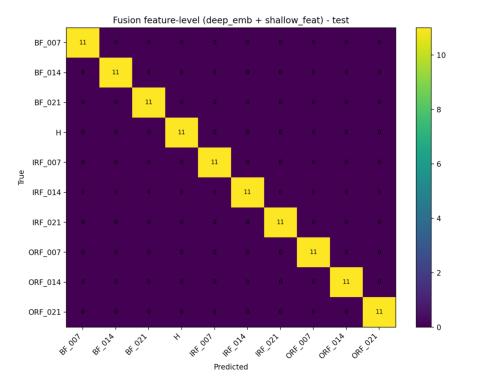

Show: C:\Users\ADMIN\Desktop\NDM_Project\results\cm_fusion_score.png


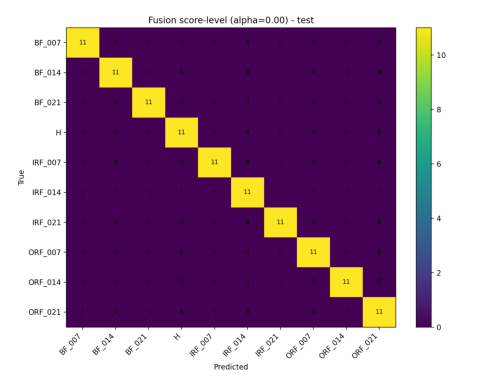

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ROOT = r"C:\Users\ADMIN\Desktop\NDM_Project"
for name in ["cm_fusion_feature.png", "cm_fusion_score.png"]:
    p = os.path.join(ROOT, "results", name)
    print("Show:", p)
    img = mpimg.imread(p)
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.show()


In [6]:
import os, json, pandas as pd
ROOT = r"C:\Users\ADMIN\Desktop\NDM_Project"
res = os.path.join(ROOT, "results")

for f in ["fusion_feature_metrics.csv","fusion_score_metrics.csv",
          "cm_fusion_feature.png","cm_fusion_score.png","fusion_phase8_info.json"]:
    print("OK" if os.path.exists(os.path.join(res,f)) else "MISS", f)

print("\n--- fusion_score_metrics.csv ---")
print(pd.read_csv(os.path.join(res,"fusion_score_metrics.csv")).head())

print("\n--- fusion_feature_metrics.csv ---")
print(pd.read_csv(os.path.join(res,"fusion_feature_metrics.csv")).head())

print("\n--- fusion_phase8_info.json ---")
info = json.load(open(os.path.join(res,"fusion_phase8_info.json"),"r",encoding="utf-8"))
print(info["best"] if "best" in info else info.keys())


OK fusion_feature_metrics.csv
OK fusion_score_metrics.csv
OK cm_fusion_feature.png
OK cm_fusion_score.png
OK fusion_phase8_info.json

--- fusion_score_metrics.csv ---
                     method  alpha  shallow_best_C  val_acc  val_macro_f1  \
0  score_level_weighted_sum    0.0             1.0      1.0           1.0   

   test_acc  test_macro_f1  
0       1.0            1.0  

--- fusion_feature_metrics.csv ---
                 method  fused_best_C  val_acc  val_macro_f1  test_acc  \
0  feature_level_concat           0.1      1.0           1.0       1.0   

   test_macro_f1  deep_dim  shallow_dim  fused_dim  
0            1.0       128           23        151  

--- fusion_phase8_info.json ---
dict_keys(['class_names', 'score_level', 'feature_level'])
